This code compute virtual temperature (Tv) lapse rates as well as Tv vertical profiles in ERA5 data. It then produces a five panel plot of vertical structure of each of these fields at 7.5 S and the EQ.

Author: Alex Gonzalez (alex.gonzalez@whoi.edu). Oct 2023.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
#from netCDF4 import Dataset
import pandas as pd
import netCDF4

#from cartopy import config
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#from cartopy.util import add_cyclic_point

from mpl_toolkits.axes_grid1 import ImageGrid

In [4]:
figfolder = '/Users/alexgonzalez/Google Drive/My Drive/ITCZ_sblm_1D/ERA5/figures/'

dri = '/Volumes/alex.gonzalez/ERA5_smooth_clm/'

fn  = 'tv_1979-2021_monclm_hres.nc'
data_tv = xr.open_dataset(dri+fn)

fn  = 'ta_1979-2021_monclm_hres.nc'
data_ta = xr.open_dataset(dri+fn)

fn  = 'sh_1979-2021_monclm_hres.nc'
data_sh = xr.open_dataset(dri+fn)

fn  = 'sst_1979-2021_monclm_hres.nc'
data_sst = xr.open_dataset(dri+fn)

In [5]:
data_ta

<xarray.Dataset>
Dimensions:    (time: 12, bnds: 2, longitude: 1440, latitude: 721, level: 12)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 700 750 775 800 825 850 875 900 925 950 975 1000
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    t          (time, level, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue May 09 13:00:46 2023: cdo ymonavg ta_1979-2021_hres.nc ...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [6]:
lats = -30
latn = 30
lonw = 235
lone = 270

lev0 = 700
lev1 = 1000

In [7]:
data_tv

<xarray.Dataset>
Dimensions:    (time: 12, bnds: 2, longitude: 1440, latitude: 721, level: 12)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 700 750 775 800 825 850 875 900 925 950 975 1000
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    tv         (time, level, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 11 16:15:15 2023: cdo ymonavg tv_1979-2021_hres.nc ...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [8]:
# set up conditional statements 
cond1a = (data_tv['time']['time.month'] == 3) # month of interest
#cond1b = (data['time']['time.month'] <= 4) # month of interest
time1 = data_tv['time'].where(cond1a, drop=True) # & cond1b, drop=True) 

# set up conditional statements 
cond2a = (data_tv['time']['time.month'] == 9) # month of interest
#cond2b = (data['time']['time.month'] <= 10) # month of interest
time2 = data_tv['time'].where(cond2a, drop=True) # & cond2b, drop=True) 

month1 = 'Mar'
month2 = 'Sep'

In [9]:
tv = data_tv['tv'][:,:,::-1,:].sel(level=slice(lev0,lev1),latitude=slice(lats,latn),longitude=slice(lonw,lone))

In [10]:
ta = data_ta['t'][:,:,::-1,:].sel(level=slice(lev0,lev1),latitude=slice(lats,latn),longitude=slice(lonw,lone))

In [11]:
tv

<xarray.DataArray 'tv' (time: 12, level: 12, latitude: 241, longitude: 141)>
[4893264 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 269.5 269.8 270.0
  * latitude   (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
  * level      (level) int32 700 750 775 800 825 850 875 900 925 950 975 1000
Attributes:
    standard_name:  virtual_temperature
    long_name:      Virtual Temperature
    units:          K

In [12]:
# calculate d(?)/dp
def center_fd(field_monlevlatlon,lev):
    [nmon,nlev,nlat,nlon] = field_monlevlatlon.shape
    field = np.swapaxes(field_monlevlatlon,1,3) # swap lev and lon axes # Python's fastest varying dimension/axis is the rightmost
    
    dfdp = np.zeros((nmon,nlon,nlat,nlev))
    dfdp[:,:,:,1:nlev-1] = (field[:,:,:,2:nlev] - field[:,:,:,0:nlev-2])/(lev[2:nlev] - lev[0:nlev-2]) # central finite difference everywhere but edges
    dfdp[:,:,:,0]        = (field[:,:,:,1] - field[:,:,:,0])/(lev[1] - lev[0]) # forward finite difference at first edge
    dfdp[:,:,:,nlev-1]   = (field[:,:,:,nlev-1] - field[:,:,:,nlev-2])/(lev[nlev-1] - lev[nlev-2]) # backward finite difference
    dfdp_final = np.swapaxes(dfdp,3,1)  # swap lev and lon axes 
    return dfdp_final

In [13]:
lev = tv['level']

In [14]:
dTv_dp = center_fd(tv.values,lev.values*100) + tv*0

In [15]:
dTa_dp = center_fd(ta.values,lev.values*100) + ta*0

In [16]:
# land-sea mask
fn_lsm = '/Volumes/alex.gonzalez/ERA5_smooth_clm/lsm_era5.nc'# load the land-sea mask here and do a where statement further down   
data_lsm = xr.open_dataset(fn_lsm)
lsm = data_lsm['lsm'][0,::-1,:].sel(latitude=slice(lats,latn),longitude=slice(lonw,lone))

In [17]:
lsm

<xarray.DataArray 'lsm' (latitude: 241, longitude: 141)>
array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.634184, 0.592892, 0.445623],
       [0.      , 0.      , 0.      , ..., 0.83831 , 0.769277, 0.762959],
       [0.      , 0.      , 0.      , ..., 0.714556, 0.702074, 0.688584]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 269.5 269.8 270.0
  * latitude   (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
    time       datetime64[ns] 1979-01-01
Attributes:
    units:          (0 - 1)
    long_name:      Land-sea mask
    standard_name:  land_binary_mask

In [18]:
tv_yz = tv.where(lsm==0).mean(dim=('longitude')) 
#tv_yz

In [19]:
ta_yz = ta.where(lsm==0).mean(dim=('longitude')) 

In [20]:
dTv_dp_yz = dTv_dp.where(lsm==0).mean(dim=('longitude'))

In [21]:
dTa_dp_yz = dTa_dp.where(lsm==0).mean(dim=('longitude')) 

In [22]:
dTv_dp_yz_plt = dTv_dp_yz*100*100 # K per 100 hPa
dTa_dp_yz_plt = dTa_dp_yz*100*100 # K per 100 hPa

In [23]:
tv_yz_plt_15S = tv_yz.sel(latitude=-15)
tv_yz_plt_9S = tv_yz.sel(latitude=-8.75)
tv_yz_plt_7S = tv_yz.sel(latitude=-7.5)
tv_yz_plt_EQ = tv_yz.sel(latitude=0)
tv_yz_plt_4N = tv_yz.sel(latitude=4)

In [24]:
ta_yz_plt_15S = ta_yz.sel(latitude=-15)
ta_yz_plt_9S = ta_yz.sel(latitude=-8.75)
ta_yz_plt_7S = ta_yz.sel(latitude=-7.5)
ta_yz_plt_EQ = ta_yz.sel(latitude=0)
ta_yz_plt_4N = ta_yz.sel(latitude=4)

In [25]:
dTv_dp_yz_plt_15S = dTv_dp_yz_plt.sel(latitude=-15)
dTv_dp_yz_plt_9S = dTv_dp_yz_plt.sel(latitude=-8.75)
dTv_dp_yz_plt_7S = dTv_dp_yz_plt.sel(latitude=-7.5)
dTv_dp_yz_plt_EQ = dTv_dp_yz_plt.sel(latitude=0)
dTv_dp_yz_plt_4N = dTv_dp_yz_plt.sel(latitude=4)

In [26]:
dTa_dp_yz_plt_15S = dTa_dp_yz_plt.sel(latitude=-15)
dTa_dp_yz_plt_9S = dTa_dp_yz_plt.sel(latitude=-8.75)
dTa_dp_yz_plt_7S = dTa_dp_yz_plt.sel(latitude=-7.5)
dTa_dp_yz_plt_EQ = dTa_dp_yz_plt.sel(latitude=0)
dTa_dp_yz_plt_4N = dTa_dp_yz_plt.sel(latitude=4)

In [27]:
latS = -20
latN = 20
tv_yz_plt_15S_anom = tv_yz_plt_15S - tv_yz.sel(latitude=slice(latS,latN)).mean(dim='latitude')
tv_yz_plt_9S_anom = tv_yz_plt_9S - tv_yz.sel(latitude=slice(latS,latN)).mean(dim='latitude')
tv_yz_plt_7S_anom = tv_yz_plt_7S - tv_yz.sel(latitude=slice(latS,latN)).mean(dim='latitude')
tv_yz_plt_EQ_anom = tv_yz_plt_EQ - tv_yz.sel(latitude=slice(latS,latN)).mean(dim='latitude')

In [28]:
ta_yz_plt_15S_anom = ta_yz_plt_15S - ta_yz.sel(latitude=slice(latS,latN)).mean(dim='latitude')
ta_yz_plt_9S_anom = ta_yz_plt_9S - ta_yz.sel(latitude=slice(latS,latN)).mean(dim='latitude')
ta_yz_plt_7S_anom = ta_yz_plt_7S - ta_yz.sel(latitude=slice(latS,latN)).mean(dim='latitude')
ta_yz_plt_EQ_anom = ta_yz_plt_EQ - ta_yz.sel(latitude=slice(latS,latN)).mean(dim='latitude')

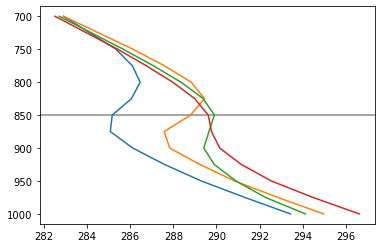

In [29]:
plt.plot(ta_yz_plt_15S[8,:],lev)
plt.plot(ta_yz_plt_7S[8,:],lev)
plt.plot(ta_yz_plt_EQ[8,:],lev)
plt.plot(ta_yz_plt_4N[8,:],lev)
plt.gca().invert_yaxis()
#plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
plt.axhline(850, color='0.65', linewidth = 2.0, zorder=-1)

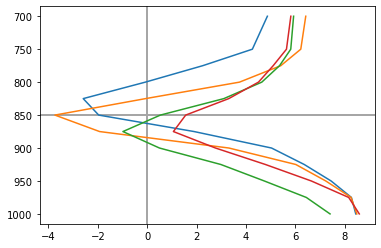

In [30]:
plt.plot(dTa_dp_yz_plt_15S[8,:],lev)
plt.plot(dTa_dp_yz_plt_7S[8,:],lev)
plt.plot(dTa_dp_yz_plt_EQ[8,:],lev)
plt.plot(dTa_dp_yz_plt_4N[8,:],lev)
plt.gca().invert_yaxis()
plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
plt.axhline(850, color='0.65', linewidth = 2.0, zorder=-1)

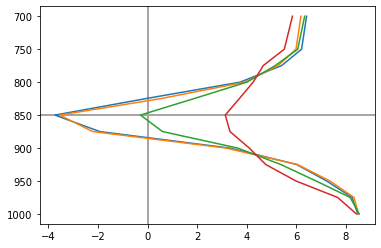

In [31]:
plt.plot(dTa_dp_yz_plt_7S[8,:],lev)
plt.plot(dTa_dp_yz_plt_7S[10,:],lev)
plt.plot(dTa_dp_yz_plt_7S[0,:],lev)
plt.plot(dTa_dp_yz_plt_7S[2,:],lev)
plt.gca().invert_yaxis()
plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
plt.axhline(850, color='0.65', linewidth = 2.0, zorder=-1)

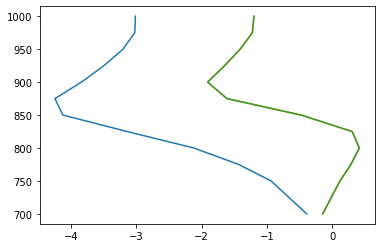

In [32]:
plt.plot(tv_yz_plt_15S_anom[8,:],lev)
plt.plot(tv_yz_plt_7S_anom[8,:],lev)
plt.plot(tv_yz_plt_7S_anom[8,:],lev)

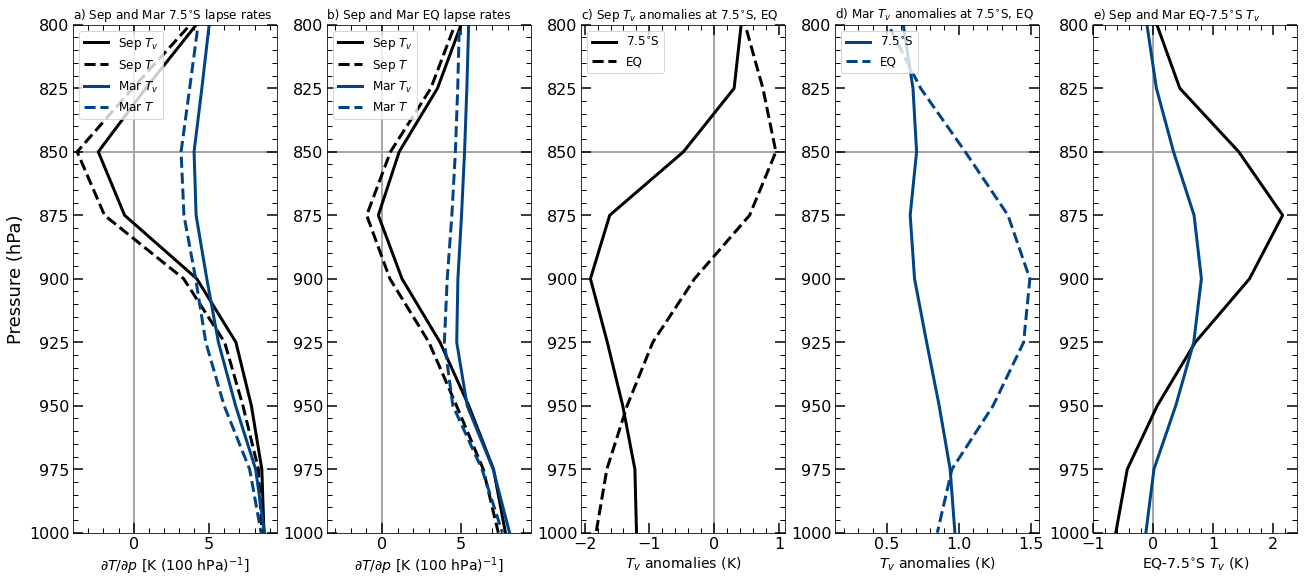

In [34]:
npan = 5
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(18, 8), constrained_layout=True)
#fig.suptitle(r'September East Pacific Virtual Temperature at 7.5$^{\circ}$S, EQ', fontsize=18)#, y=0.78)
for jj in range(0,npan,1):
   ax1 = fig.add_subplot(1,npan,jj+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
  
   ax1.tick_params(axis='x', labelsize=16)
   ax1.tick_params(axis='y', labelsize=16)
   plt.gca().invert_yaxis()
   plt.ylim(1000,800)
   if jj == 0: 
      ax1.set_ylabel('Pressure (hPa)', fontsize=18)
      plt.title(r'a) Sep and Mar 7.5$^{\circ}$S lapse rates',loc='left')
      color = 'k'
      lns1 = ax1.plot(dTv_dp_yz_plt_7S[8,:], lev, color=color, linewidth='3')
      lns2 = ax1.plot(dTa_dp_yz_plt_7S[8,:], lev, color=color, linewidth='3', linestyle='--')
      color = '#004488'
      lns3 = ax1.plot(dTv_dp_yz_plt_7S[2,:], lev, color=color, linewidth='3')
      lns4 = ax1.plot(dTa_dp_yz_plt_7S[2,:], lev, color=color, linewidth='3', linestyle='--')
      plt.legend([month2+r' $T_v$',month2+r' $T$',month1+r' $T_v$',month1+r' $T$'],loc=2,fontsize=12)
      plt.xlim(-4.0,9.5)
      plt.xlabel(r'$\partial T/\partial p$ [K (100 hPa)$^{-1}$]', fontsize=14)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   if jj == 1: 
      color = 'k'
      plt.title(r'b) Sep and Mar EQ lapse rates',loc='left')
      lns1 = ax1.plot(dTv_dp_yz_plt_EQ[8,:], lev, color=color, linewidth='3')
      lns2 = ax1.plot(dTa_dp_yz_plt_EQ[8,:], lev, color=color, linewidth='3', linestyle='--')
      color = '#004488'
      lns3 = ax1.plot(dTv_dp_yz_plt_EQ[2,:], lev, color=color, linewidth='3')
      lns4 = ax1.plot(dTa_dp_yz_plt_EQ[2,:], lev, color=color, linewidth='3', linestyle='--')
      plt.legend([month2+r' $T_v$',month2+r' $T$',month1+r' $T_v$',month1+r' $T$'],loc=2,fontsize=12)
      plt.xlim(-3.5,9.5)
      plt.xlabel(r'$\partial T/\partial p$ [K (100 hPa)$^{-1}$]', fontsize=14)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   if jj == 2: 
      color = 'k'
      plt.title(r'c) Sep $T_v$ anomalies at 7.5$^{\circ}$S, EQ',loc='left')
      lns1 = ax1.plot(tv_yz_plt_7S_anom[8,:], lev, color=color, linewidth='3')
      lns2 = ax1.plot(tv_yz_plt_EQ_anom[8,:], lev, color=color, linewidth='3', linestyle='--')
      #plt.xlim(-1.8,2.2)
      plt.xlabel(r'$T_v$ anomalies (K)', fontsize=14)
      plt.legend(['7.5$^{\circ}$S','EQ'],loc=2,fontsize=12)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   if jj == 3: 
      color = '#004488'
      plt.title(r'd) Mar $T_v$ anomalies at 7.5$^{\circ}$S, EQ',loc='left')
      lns1 = ax1.plot(tv_yz_plt_7S_anom[2,:], lev, color=color, linewidth='3')
      lns2 = ax1.plot(tv_yz_plt_EQ_anom[2,:], lev, color=color, linewidth='3', linestyle='--')
      #plt.xlim(0.8,3.2)
      plt.xlabel(r'$T_v$ anomalies (K)', fontsize=14)
      plt.legend(['7.5$^{\circ}$S','EQ'],loc=2,fontsize=12)
   if jj == 4: 
      color = 'k'
      plt.title(r'e) Sep and Mar EQ-7.5$^{\circ}$S $T_v$',loc='left')
      lns1 = ax1.plot( (tv_yz_plt_EQ-tv_yz_plt_7S)[8,:], lev, color=color, linewidth='3')
      color = '#004488'
      lns1 = ax1.plot( (tv_yz_plt_EQ-tv_yz_plt_7S)[2,:], lev, color=color, linewidth='3')
      plt.xlabel(r'EQ-7.5$^{\circ}$S $T_v$ (K)', fontsize=14)
      #plt.legend([month2,month1],loc=2,fontsize=12)
      plt.xlim(-1.0,2.4)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   plt.axhline(850, color='0.65', linewidth = 2.0, zorder=-1)
   
   #ax1.tick_params(axis='y', labelsize=16)
   #ax1.tick_params(axis='y', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', left='True')
   #ax1.tick_params(axis='y', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', left='True')

figname = 'Lapse_tv_moist_dry_prof.pdf'
#plt.savefig(figfolder+figname, dpi=150)

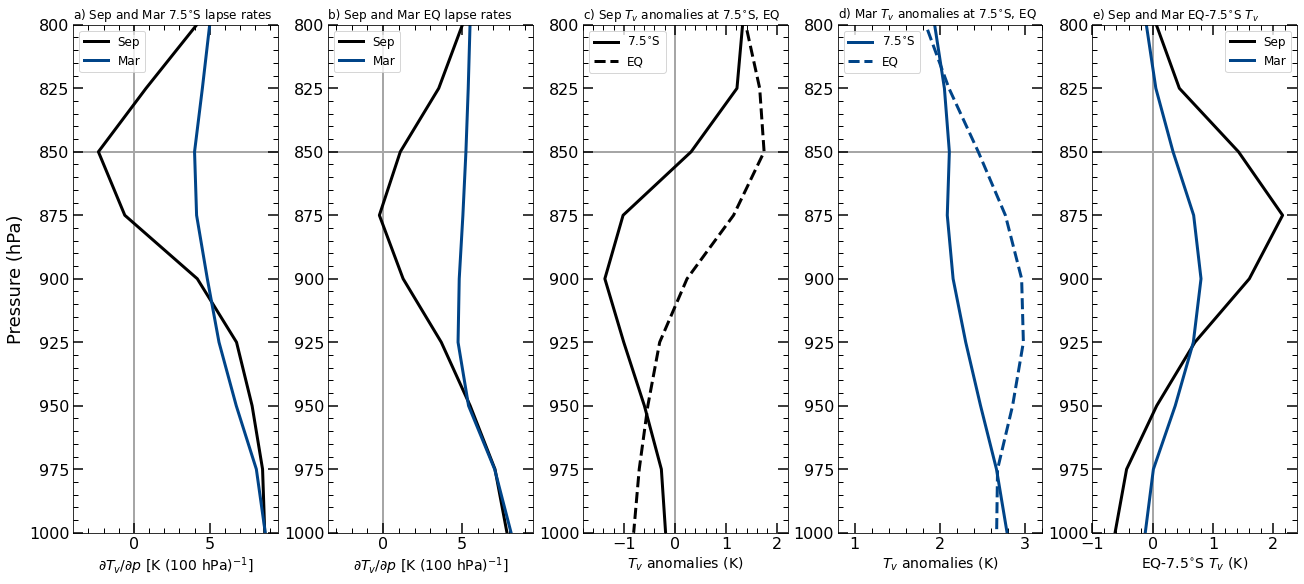

In [79]:
npan = 5
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(18, 8), constrained_layout=True)
#fig.suptitle(r'September East Pacific Virtual Temperature at 7.5$^{\circ}$S, EQ', fontsize=18)#, y=0.78)
for jj in range(0,npan,1):
   ax1 = fig.add_subplot(1,npan,jj+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
  
   ax1.tick_params(axis='x', labelsize=16)
   ax1.tick_params(axis='y', labelsize=16)
   plt.gca().invert_yaxis()
   plt.ylim(1000,800)
   if jj == 0: 
      ax1.set_ylabel('Pressure (hPa)', fontsize=18)
      plt.title(r'a) Sep and Mar 7.5$^{\circ}$S lapse rates',loc='left')
      color = 'k'
      lns1 = ax1.plot(dTv_dp_yz_plt_7S[8,:], lev, color=color, linewidth='3')
      color = '#004488'
      lns3 = ax1.plot(dTv_dp_yz_plt_7S[2,:], lev, color=color, linewidth='3')
      plt.legend([month2,month1],loc=2,fontsize=12)
      plt.xlim(-4.0,9.5)
      plt.xlabel(r'$\partial T_v/\partial p$ [K (100 hPa)$^{-1}$]', fontsize=14)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   if jj == 1: 
      color = 'k'
      lns1 = ax1.plot(dTv_dp_yz_plt_EQ[8,:], lev, color=color, linewidth='3')
      plt.title(r'b) Sep and Mar EQ lapse rates',loc='left')
      color = '#004488'
      lns3 = ax1.plot(dTv_dp_yz_plt_EQ[2,:], lev, color=color, linewidth='3')
      plt.legend([month2,month1],loc=2,fontsize=12)
      plt.xlim(-3.5,9.5)
      plt.xlabel(r'$\partial T_v/\partial p$ [K (100 hPa)$^{-1}$]', fontsize=14)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   if jj == 2: 
      color = 'k'
      plt.title(r'c) Sep $T_v$ anomalies at 7.5$^{\circ}$S, EQ',loc='left')
      lns1 = ax1.plot(tv_yz_plt_7S_anom[8,:], lev, color=color, linewidth='3')
      lns2 = ax1.plot(tv_yz_plt_EQ_anom[8,:], lev, color=color, linewidth='3', linestyle='--')
      plt.xlim(-1.8,2.2)
      plt.xlabel(r'$T_v$ anomalies (K)', fontsize=14)
      plt.legend(['7.5$^{\circ}$S','EQ'],loc=2,fontsize=12)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   if jj == 3: 
      color = '#004488'
      plt.title(r'd) Mar $T_v$ anomalies at 7.5$^{\circ}$S, EQ',loc='left')
      lns1 = ax1.plot(tv_yz_plt_7S_anom[2,:], lev, color=color, linewidth='3')
      lns2 = ax1.plot(tv_yz_plt_EQ_anom[2,:], lev, color=color, linewidth='3', linestyle='--')
      plt.xlim(0.8,3.2)
      plt.xlabel(r'$T_v$ anomalies (K)', fontsize=14)
      plt.legend(['7.5$^{\circ}$S','EQ'],loc=2,fontsize=12)
   if jj == 4: 
      color = 'k'
      plt.title(r'e) Sep and Mar EQ-7.5$^{\circ}$S $T_v$',loc='left')
      lns1 = ax1.plot( (tv_yz_plt_EQ-tv_yz_plt_7S)[8,:], lev, color=color, linewidth='3')
      color = '#004488'
      lns1 = ax1.plot( (tv_yz_plt_EQ-tv_yz_plt_7S)[2,:], lev, color=color, linewidth='3')
      plt.xlabel(r'EQ-7.5$^{\circ}$S $T_v$ (K)', fontsize=14)
      plt.legend([month2,month1],loc=1,fontsize=12)
      plt.xlim(-1.0,2.4)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   plt.axhline(850, color='0.65', linewidth = 2.0, zorder=-1)
   
   #ax1.tick_params(axis='y', labelsize=16)
   #ax1.tick_params(axis='y', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', left='True')
   #ax1.tick_params(axis='y', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', left='True')

figname = 'Lapse_tv_prof.pdf'
plt.savefig(figfolder+figname, dpi=150)

In [ ]:
npan = 5
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(18, 8), constrained_layout=True)
#fig.suptitle(r'September East Pacific Virtual Temperature at 7.5$^{\circ}$S, EQ', fontsize=18)#, y=0.78)
for jj in range(0,npan,1):
   ax1 = fig.add_subplot(1,npan,jj+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
  
   ax1.tick_params(axis='x', labelsize=16)
   ax1.tick_params(axis='y', labelsize=16)
   plt.gca().invert_yaxis()
   plt.ylim(1000,800)
   if jj == 0: 
      ax1.set_ylabel('Pressure (hPa)', fontsize=18)
      plt.title(r'a) Sep and Mar 7.5$^{\circ}$S lapse rates',loc='left')
      color = 'k'
      lns1 = ax1.plot(dTv_dp_yz_plt_7S[8,:], lev, color=color, linewidth='3')
      color = '#004488'
      lns3 = ax1.plot(dTv_dp_yz_plt_7S[2,:], lev, color=color, linewidth='3')
      plt.legend([month2,month1],loc=2,fontsize=12)
      plt.xlim(-4.0,9.5)
      plt.xlabel(r'$\partial T_v/\partial p$ [K (100 hPa)$^{-1}$]', fontsize=14)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   if jj == 1: 
      color = 'k'
      lns1 = ax1.plot(dTv_dp_yz_plt_EQ[8,:], lev, color=color, linewidth='3')
      plt.title(r'b) Sep and Mar EQ lapse rates',loc='left')
      color = '#004488'
      lns3 = ax1.plot(dTv_dp_yz_plt_EQ[2,:], lev, color=color, linewidth='3')
      plt.legend([month2,month1],loc=2,fontsize=12)
      plt.xlim(-3.5,9.5)
      plt.xlabel(r'$\partial T_v/\partial p$ [K (100 hPa)$^{-1}$]', fontsize=14)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   if jj == 2: 
      color = 'k'
      plt.title(r'c) Sep $T_v$ anomalies at 7.5$^{\circ}$S, EQ',loc='left')
      lns1 = ax1.plot(tv_yz_plt_7S_anom[8,:], lev, color=color, linewidth='3')
      lns2 = ax1.plot(tv_yz_plt_EQ_anom[8,:], lev, color=color, linewidth='3', linestyle='--')
      #plt.xlim(-4.5,0)
      plt.xlabel(r'$T_v$ anomalies (K)', fontsize=14)
      plt.legend(['7.5$^{\circ}$S','EQ'],loc=2,fontsize=12)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   if jj == 3: 
      color = '#004488'
      plt.title(r'd) Mar $T_v$ anomalies at 7.5$^{\circ}$S, EQ',loc='left')
      lns1 = ax1.plot(tv_yz_plt_7S_anom[2,:], lev, color=color, linewidth='3')
      lns2 = ax1.plot(tv_yz_plt_EQ_anom[2,:], lev, color=color, linewidth='3', linestyle='--')
      plt.xlim(1,3.2)
      plt.xlabel(r'$T_v$ anomalies (K)', fontsize=14)
      plt.legend(['7.5$^{\circ}$S','EQ'],loc=2,fontsize=12)
   if jj == 4: 
      color = 'k'
      plt.title(r'e) Sep and Mar EQ-7.5$^{\circ}$S $T_v$',loc='left')
      lns1 = ax1.plot( (tv_yz_plt_EQ-tv_yz_plt_7S)[8,:], lev, color=color, linewidth='3')
      color = '#004488'
      lns1 = ax1.plot( (tv_yz_plt_EQ-tv_yz_plt_7S)[2,:], lev, color=color, linewidth='3')
      plt.xlabel(r'EQ-7.5$^{\circ}$S $T_v$ (K)', fontsize=14)
      plt.legend([month2,month1],loc=1,fontsize=12)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   plt.axhline(850, color='0.65', linewidth = 2.0, zorder=-1)
   
   #ax1.tick_params(axis='y', labelsize=16)
   #ax1.tick_params(axis='y', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', left='True')
   #ax1.tick_params(axis='y', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', left='True')

figname = 'Lapse_tv_prof_anom2.pdf'
plt.savefig(figfolder+figname, dpi=150)

In [29]:
tv_yz_anom = tv_yz - tv_yz.sel(latitude=slice(-30,30)).mean(dim='latitude')
ta_yz_anom = ta_yz - ta_yz.sel(latitude=slice(-30,30)).mean(dim='latitude')

In [30]:
print(tv_yz_anom.max())
print(tv_yz_anom.min())

<xarray.DataArray 'tv' ()>
array(5.57015991)
<xarray.DataArray 'tv' ()>
array(-10.56030273)


In [52]:
# create density contour array based on min and max values
lev_dT = np.arange(-6.,6.5, 0.5)
color_map_rb = plt.cm.get_cmap('RdBu').reversed()

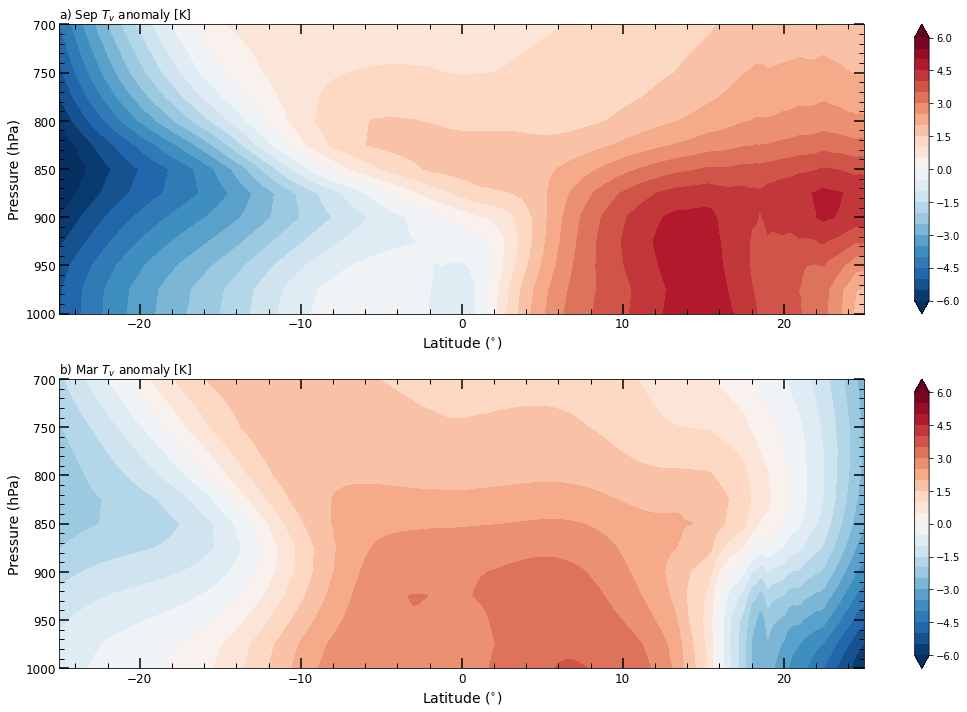

In [53]:
npan = 2
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(15,10), tight_layout='true')
#fig.suptitle('Slab boundary layer model vs. ERA5 climatology for control run', fontsize=20)
for j in range(0,npan,1):
   ax1 = fig.add_subplot(npan,1,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', labelsize=12)
   ax1.tick_params(axis='y', labelsize=12)
   plt.gca().invert_yaxis()
   plt.ylabel('Pressure (hPa)', fontsize=14)
   plt.xlabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.xlim(-25,25)
   #plt.ylim(1000,850)
   if j == 0:
       plt.title(r'a) Sep $T_v$ anomaly [K]',loc='left')
       cf = plt.contourf(tv_yz_anom['latitude'],tv_yz_anom['level'],tv_yz_anom[8,:,:], cmap = color_map_rb, levels=lev_dT, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 1:
       plt.title(r'b) Mar $T_v$ anomaly [K]',loc='left')
       cf = plt.contourf(tv_yz_anom['latitude'],tv_yz_anom['level'],tv_yz_anom[2,:,:], cmap = color_map_rb, levels=lev_dT, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
        
figname = 'Sep_Mar_Tv_anom_wide.pdf'
#plt.savefig(figfolder+figname, dpi=150)

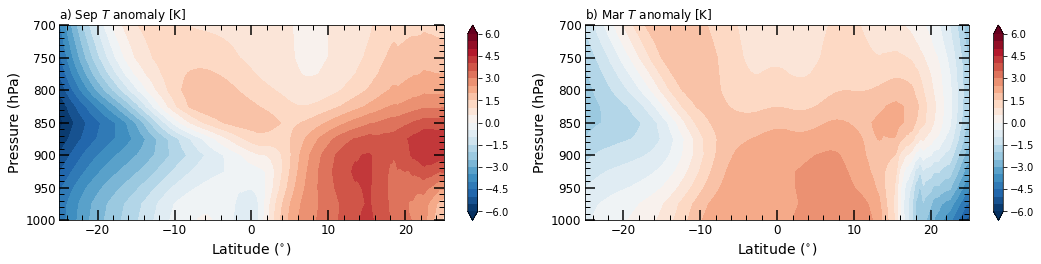

In [48]:
npan = 2
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(15,10), tight_layout='true')
#fig.suptitle('Slab boundary layer model vs. ERA5 climatology for control run', fontsize=20)
for j in range(0,npan,1):
   ax1 = fig.add_subplot(3,2,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', labelsize=12)
   ax1.tick_params(axis='y', labelsize=12)
   plt.gca().invert_yaxis()
   plt.ylabel('Pressure (hPa)', fontsize=14)
   plt.xlabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.xlim(-25,25)
   #plt.ylim(1000,850)
   if j == 0:
       plt.title(r'a) Sep $T$ anomaly [K]',loc='left')
       cf = plt.contourf(tv_yz_anom['latitude'],tv_yz_anom['level'],ta_yz_anom[8,:,:], cmap = color_map_rb, levels=lev_dT, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 1:
       plt.title(r'b) Mar $T$ anomaly [K]',loc='left')
       cf = plt.contourf(tv_yz_anom['latitude'],tv_yz_anom['level'],ta_yz_anom[2,:,:], cmap = color_map_rb, levels=lev_dT, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')